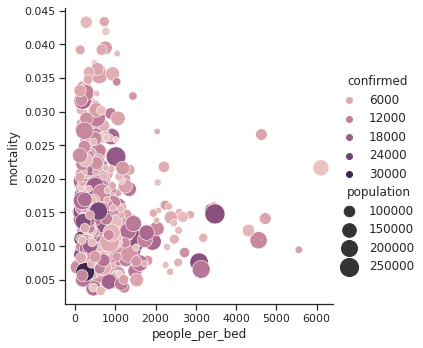

In [1]:
import requests
import pandas as pd
import json
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

req=requests.get("https://www.communitybenefitinsight.org/api/get_hospitals.php").json()
hospitals=pd.DataFrame(req)
hospitals.head()

hospitals['state_county']=hospitals['state']+'_'+hospitals['county']
hospitals.head()

hospitals["hospital_bed_count"] = pd.to_numeric(hospitals["hospital_bed_count"])
HospitalInfoPerCounty=hospitals.groupby(['state_county'], as_index=False)['hospital_bed_count'].agg('sum')
HospitalInfoPerCounty.head()

HospitalInfoPerCounty['state_county']=HospitalInfoPerCounty['state_county'].str.replace(' County','')
HospitalInfoPerCounty.head(5)

req=requests.get("https://webhooks.mongodb-stitch.com/api/client/v2.0/app/covid-19-qppza/service/REST-API/incoming_webhook/us_only?min_date=2021-01-15T00:00:00.000Z&max_date=2021-01-15T00:00:00.000Z").json()
covid=pd.DataFrame(req)

us_state_to_abbrev = {
"Alabama": "AL","Alaska": "AK","Arizona": "AZ","Arkansas": "AR", "California": "CA",
"Colorado": "CO","Connecticut": "CT","Delaware": "DE","Florida": "FL","Georgia": "GA",
"Hawaii": "HI","Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA","Kansas": "KS",
"Kentucky": "KY","Louisiana": "LA","Maine": "ME","Maryland": "MD","Massachusetts": "MA",
"Michigan": "MI","Minnesota": "MN","Mississippi": "MS","Missouri": "MO","Montana": "MT",
"Nebraska": "NE","Nevada": "NV","New Hampshire": "NH","New Jersey": "NJ","New Mexico": "NM",
"New York": "NY","North Carolina": "NC","North Dakota": "ND","Ohio": "OH",
"Oklahoma": "OK","Oregon": "OR","Pennsylvania": "PA","Rhode Island": "RI",
"South Carolina": "SC","South Dakota": "SD","Tennessee": "TN","Texas": "TX",
"Utah": "UT","Vermont": "VT","Virginia": "VA","Washington": "WA",
"West Virginia": "WV","Wisconsin": "WI","Wyoming": "WY",
"District of Columbia": "DC","American Samoa": "AS","Guam": "GU", "Northern Mariana Islands": "MP",
"Puerto Rico": "PR","United States Minor Outlying Islands": "UM","U.S. Virgin Islands": "VI",
}
covid['state'].replace(us_state_to_abbrev, inplace=True)
covid.head(5)

covid['state_county']=covid['state']+'_'+covid['county']
covid.head()

CovidPerCounty=covid.groupby(['state_county'], as_index=False).agg({'deaths':'sum','confirmed':'sum','population':'sum','confirmed_daily':'mean','deaths_daily':'mean'})
CovidPerCounty.head(15)

CovidPerCounty['mortality']=CovidPerCounty['deaths']/CovidPerCounty['confirmed']
CovidPerCounty.head(5)

Hospital_Covid_PerCounty=pd.merge(HospitalInfoPerCounty,CovidPerCounty,on='state_county')
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['population']>50000]
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['population']<300000]
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['confirmed']>10]
Hospital_Covid_PerCounty["people_per_bed"] = Hospital_Covid_PerCounty["population"]/Hospital_Covid_PerCounty["hospital_bed_count"]
Hospital_Covid_PerCounty.head()

sns.set_theme(style="ticks")
sns.relplot(data=Hospital_Covid_PerCounty, x="people_per_bed", y="mortality", hue="confirmed", size="population", sizes=(40, 400))